# Masked Autoencoders (MAE)

MAEはViTのための優秀な事前学習法として提案された  
そのMAEを実装する

Reference
- https://github.com/facebookresearch/mae
    - 公式実装
- https://arxiv.org/abs/2111.06377
    - 論文

バックボーン（というかモデル全体）はViTをベースとしているのでまずはViTの実装から

In [36]:
# ViT (Vision Transformerノートブック参照)

import torch.nn as nn
import collections
import numpy as np

class ImagePatchEmbedding(nn.Module):
    """
    input: image:torch.Tensor[n,c,h,w]
    output: embedding_vector:torch.Tensor[n,p,dim]
    
    nはバッチサイズ、chwは画像のカラーチャネル、高さ、幅であり、pはトークン数（＝パッチの個数）
    dimは埋め込みベクトルの長さ（ハイパーパラメータ）
    """
    def __init__(self,image_size=224,patch_size=16,in_channel=3,embedding_dim=768):
        """
        args:
            image_size:Union[int, tuple] 画像の高さと幅
            patch_size:int 1画像パッチのピクセル幅
            in_channel:int 入力画像のチャネル数
            embeedding_dim:int トークン（埋め込みベクトル）の長さ
        """
        super().__init__()
        image_size = self._pair(image_size) # if int -> tuple
        patch_size = self._pair(patch_size)
        self.image_size = image_size
        self.patch_size = patch_size
        self.grid_size = (image_size[0]//patch_size[0], image_size[1]//patch_size[1])
        self.num_patches = self.grid_size[0]*self.grid_size[1]

        self.proj = nn.Conv2d(in_channel,embedding_dim,patch_size,patch_size)
        #self.normalize = nn.LayerNorm(embedding_dim)
    
    def forward(self,x):
        """
        x:torch.Tensor[b,c,h,w]
        -> torch.Tensor[b,p,dim]
        """
        n,c,h,w = x.shape
        assert h == self.image_size[0] and w == self.image_size[1], f'Input image size ({h}*{w}) doesn\'t match model ({self.image_size[0]}*{self.image_size[1]}).'

        x = self.proj(x)
        x = x.flatten(2).transpose(1,2) # (N,C,H,W) -> (B,P,C)
        #x = self.normalize(x)
        return x

    def _pair(self,x):
        """
        util function
        return a tuple if x is int 
        """
        return x if isinstance(x, collections.abc.Iterable) else (x, x)
        #return x if isinstance(x, tuple) else (x, x)

In [37]:
class MultiHeadSelfAttention(nn.Module):
    """
    input: embedding_vector:torch.Tensor[n,p,dim]
    output: embedding_vector:torch.Tensor[n,p,dim]
    """
    def __init__(self,dim,num_heads=8,qkv_bias=True,dropout=0.):
        """
        args:
            dim: int トークン（埋め込みベクトル）の長さ
            num_heads: int マルチヘッドの数
            qkv_bias: bool query,key,valueに埋め込む際の全結合層のバイアス
            dropout: float dropoutの確率
        """
        super().__init__()
        
        self.num_heads = num_heads
        assert dim % num_heads == 0, f"The hidden size {dim} is not a multiple of the number of head attention"
        self.hidden_dim = dim
        self.head_dim = dim // num_heads
        
        self.query = nn.Linear(dim,dim,bias=qkv_bias)
        self.key = nn.Linear(dim,dim,bias=qkv_bias)
        self.value = nn.Linear(dim,dim,bias=qkv_bias)
        
        self.dropout = nn.Dropout(p=dropout)
        self.projection = nn.Sequential(
            nn.Linear(dim,dim),
            nn.Dropout(p=dropout),
        )
    
    def forward(self,x):
        batch_size,num_patches,_ = x.size()

        # query,key,value (B,P,C) -> (B,P,C)
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        # マルチヘッドに分割
        # (B,P,C) -> (B,P,Nh,Dh)
        #multihead_qkv_shape = q.size()[:-1] + (self.num_heads, self.head_dim)
        multihead_qkv_shape = torch.Size([batch_size, num_patches, self.num_heads, self.head_dim])
        qs = q.view(multihead_qkv_shape)
        qs = qs.permute(0, 2, 1, 3)
        ks = k.view(multihead_qkv_shape)
        ks = ks.permute(0, 2, 1, 3)
        ks_T = ks.transpose(2,3)
        vs = v.view(multihead_qkv_shape)
        vs = vs.permute(0, 2, 1, 3)
        
        # (B,P,Nh,Dh) @ (B,P,Dh,Nh) -> (B,P,Nh,Nh)
        scaled_dot_product = qs@ks_T / np.sqrt(self.head_dim) 
        self_attention = nn.functional.softmax(scaled_dot_product,dim=-1)
        self_attention = self.dropout(self_attention)
        
        # (B,P,Nh,Nh) @ (B,P,Nh,Dh) -> (B,P,Nh,Dh)
        context_layer = self_attention@vs
        #context_layer = context_layer.transpose(1,2).reshape(batch_size,num_patchs,self.hidden_dim)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous().reshape(batch_size,num_patches,self.hidden_dim)
        # (B,P,Nh,Dh) -> (B,P,C)
        
        out = self.projection(context_layer)
        
        return out

class ViTFeedForward(nn.Module):
    """
    input: embedding_vector:torch.Tensor[n,p,dim]
    output: embedding_vector:torch.Tensor[n,p,dim]
    """
    def __init__(self,dim,hidden_dim=768*4,activation=nn.GELU(),dropout=0.):
        """
        args:
            dim: int トークン（埋め込みベクトル）の長さ
            hidden_dim: FeedForwardネットワークでの中間層のベクトルの長さ
                        慣例的にdim*4が使われている(少なくともViTでは)
                        本家では違うかも
            activation: torch.nn.modules.activation 活性化関数
            dropout: float dropoutの確率    
        """
        super().__init__()
        self.linear1 = nn.Linear(dim,hidden_dim)
        self.linear2 = nn.Linear(hidden_dim,dim)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        
        return x
        

class ViTBlock(nn.Module):
    def __init__(
        self,
        dim=768,
        hidden_dim=768*4,
        num_heads=12,
        activation=nn.GELU(),
        qkv_bias=True,
        dropout=0.,
    ):
        super().__init__()
        self.mhsa = MultiHeadSelfAttention(dim,num_heads,qkv_bias,dropout)
        self.ff   = ViTFeedForward(dim,hidden_dim,activation,dropout)
        self.ln = nn.LayerNorm(dim,eps=1e-10)
    
    def forward(self,x):
        """
        input: torch.Tensor[n,p,dim]
        output; torch.Tensor[n,p,dim]
        """
        z = self.ln(x)
        z = self.mhsa(z)
        x = x + z
        z = self.ln(x)
        z = self.ff(x)
        out = x + z  
        
        return out

In [38]:
class ViTEncoder(nn.Module):
    """
    todo attentionも取り出したければ取り出せるように
    """
    def __init__(
        self,
        dim=768,
        hidden_dim=768*4,
        num_heads=12,
        activation=nn.GELU(),
        qkv_bias=True,
        dropout=0.,
        num_blocks=8,
    ):
        """
        args:
            num_blocks: int ViTBlockの総数
            他は割愛
        """
        super().__init__()
        self.layer = nn.ModuleList([ViTBlock(
            dim,hidden_dim,num_heads,activation,qkv_bias,dropout
        ) for _ in range(num_blocks)])
    
    def forward(self,x):
        for i, layer_module in enumerate(self.layer):
            x = layer_module(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=224,
        patch_size=16,
        in_channel=3,
        dim=768,
        hidden_dim=768*4,
        num_heads=12,
        activation=nn.GELU(),
        num_blocks=8,
        qkv_bias=True,
        dropout=0.,
        num_classes=1000,
    ):
        """
        args:
            image_size: int 入力画像の解像度
            patch_size: int パッチ分割の際の1パッチのピクセル幅
            in_channel: int 入力画像のチャネル数
            dim: int トークン（埋め込みベクトル）の長さ
            hidden_dim: int FeedForward層でのベクトルの長さ
            num_heads: int マルチヘッドの数
            activation: torch.nn.modules.activation 活性化関数
            num_blocks: int ViTBlockの総数
            qkv_bias: bool query,key,valueに埋め込む際の全結合層のバイアス
            dropout: float dropoutの確率
            num_classes: int 出力次元数
        """
        super().__init__()
        
        # input layer
        self.patch_embedding = ImagePatchEmbedding(image_size,patch_size,in_channel,dim)
        num_patches = self.patch_embedding.num_patches
        self.cls_token = nn.Parameter(torch.randn(size=(1,1,dim))) # クラストークン（学習可能なパラメータ）
        self.positional_embedding = nn.Parameter(torch.randn(size=(1,num_patches+1,dim))) #　位置埋め込み（学習可能なパラメータ）
        
        # vit encoder 
        self.encoder = ViTEncoder(dim,hidden_dim,num_heads,activation,qkv_bias,dropout,num_blocks)
        
        # mlp head
        self.ln = nn.LayerNorm(dim,eps=1e-10)
        self.head = nn.Linear(dim,num_classes)
    
    def forward(self,x):
        x = self.patch_embedding(x)
        cls_token = self.cls_token.expand(x.shape[0],-1,-1)
        x = torch.cat((cls_token,x),dim=1) # (B,num_patches+1,embedding_dim)
        x = x + self.positional_embedding
        
        x = self.encoder(x)
        
        x = torch.index_select(x,1,torch.tensor(0,device=x.device))
        x = x.squeeze(1)
        x = self.ln(x)
        out = self.head(x)
        
        return out

Masked Autoencoderの実装
やることとしては
- エンコーダー部分
    - 入力画像パッチのマスク
- デコーダー部分
    - マスクトークン
    - アーキテクチャ自体はViTエンコーダーと一緒
    - 出力が画像になるように調整

Note:
ViTでは位置埋め込みは学習可能なパラメータとしていたがMAEではsincosの固定値埋め込みを使う。  
エンコーダ部分で大半の画像パッチをマスクするため位置関係を学習できないことや、sincosの埋め込みを使っても大して精度に影響が出ないからと考えられる。

In [39]:
# mixed sin cos pos embedding
def get_2d_sincons_pos_embed(embed_dim,grid_size,cls_token=False):
    """
    Args:
        embed_dim (int): トークンの長さ、次元数
        grid_size (int): パッチ分割の格子の縦、横の長さ 
    Returns:
        pos_embed (ndarray): [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size,dtype=np.float32)
    grid_w = np.arange(grid_size,dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0) 
    grid = grid.reshape([2, 1, grid_size, grid_size]) # (2,grid_size,grid_size) -> (2,1,grid_size,grid_size)
    
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    Args:
        embed_dim (int): トークンの長さ、次元数
        pos (ndarray): 符号化する位置のリスト: shape=(M,)
    Returns:
        ndarray: 位置埋め込みベクトル: shape(M,embed_dim)
    """
    assert embed_dim%2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim /2.
    omega = 1. / 10000**omega
    
    pos = pos.reshape(-1)
    out = np.einsum("m,d->md",pos,omega) # shape=(m,embed_dim/2)

    emb_sin = np.sin(out)
    emb_cos = np.cos(out)

    #emb = np.concatenate([emb_sin,emb_cos],axis=1) # shape=(m,embed_dim)
    
    ## ちゃんと交互にsin,cosが来るようにしまーす
    m = emb_sin.shape[0]
    emb = np.empty(shape=(m,embed_dim))
    emb[:,0::2] = emb_sin
    emb[:,1::2] = emb_cos
    
    return emb

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    """
    Args:
        embed_dim (int): トークンの長さ、次元数
        grid (ndarray): 符号化する位置のリスト: shape=(H,W)
    Returns:
        ndarray: 位置埋め込みベクトル: shape(H*W,embed_dim)
    """
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

In [114]:
class MaskedAutoencoderViT(nn.Module):
    """Masked Autoencoderの実装
    """
    def __init__(self, image_size=224, patch_size=16, in_channel=3,
                 dim=768, hidden_dim=768*4, num_heads=12, activation=nn.GELU(),
                 num_blocks=8, qkv_bias=True, dropout=0., decoder_dim=512,
                 decoder_num_blocks=8, decoder_num_heads=16):
        """
        Args:
            image_size (int): 入力画像の解像度
            patch_size (int): パッチ分割の際の1パッチのピクセル幅
            in_channel (int): 入力画像のチャネル数
            dim (int) : トークン（埋め込みベクトル）の長さ
            hidden_dim (int): FeedForward層でのベクトルの長さ、次元数
            num_heads　(int): マルチヘッドの数
            activation (torch.nn.modules.activation): 活性化関数
            num_blocks (int): エンコーダー部分のViTBlockの層数
            qkv_bias (bool): query,key,valueに埋め込む際の全結合層のバイアス
            dropout (float): dropoutの確率
            decoder_dim (int): デコーダー部分のトークン（埋め込みベクトル）の長さ
            decoder_num_blocks (int): デコーダー部分のViTBlockの層数
            decoder_num_heads (int): デコーダー部分でのマルチヘッドの数
        """
        super().__init__()
        
        # MAE encoder
        self.patch_embedding = ImagePatchEmbedding(image_size,patch_size,in_channel,dim)
        num_patches = self.patch_embedding.num_patches
        
        self.cls_token = nn.Parameter(torch.randn(size=(1,1,dim)))
        #self.positional_embedding = nn.Parameter(torch.randn(size=(1,num_patches+1,dim))) #　位置埋め込み（学習可能なパラメータ）
        self.positional_embedding = nn.Parameter(torch.zeros(size=(1,1+num_patches,dim)),requires_grad=False) # fixed sin-cos embedding
        
        self.encoder = nn.ModuleList([
            ViTBlock(dim,hidden_dim,num_heads,activation,qkv_bias,dropout)
            for _ in range(num_blocks)])
        self.encoder_norm = nn.LayerNorm(dim,eps=1e-10)
        
        # MAE decoder
        self.decoder_embedding = nn.Linear(dim,decoder_dim)
        self.mask_token = nn.Parameter(torch.randn(size=(1,1,decoder_dim)))
        self.decoder_pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_dim), requires_grad=False)  # fixed sin-cos embedding
        
        self.decoder = nn.ModuleList([
            ViTBlock(decoder_dim,decoder_dim*4,decoder_num_heads,activation,qkv_bias,dropout)
            for _ in range(decoder_num_blocks)])
        self.decoder_norm = nn.LayerNorm(decoder_dim,eps=1e-10)
    
        self.decoder_pred = nn.Linear(decoder_dim, patch_size**2 * in_channel)
        self.initialize_weights() # pos embeddingのinit
    
    def initialize_weights(self):
        """sin,cosによる位置埋め込みの初期化
        """
        # Positional Embedding
        pe = get_2d_sincons_pos_embed(self.positional_embedding.shape[-1] ,self.patch_embedding.grid_size[0], cls_token=True)
        self.positional_embedding.data.copy_(torch.from_numpy(pe).float().unsqueeze(0))
        
        dec_pe = get_2d_sincons_pos_embed(self.decoder_pos_embedding.shape[-1] ,self.patch_embedding.grid_size[0], cls_token=True)
        self.decoder_pos_embedding.data.copy_(torch.from_numpy(dec_pe).float().unsqueeze(0))
        
        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        # これどれくらい効果あるんだろ
        w = self.patch_embedding.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)
        
        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
    
    def random_masking(self,x,mask_ratio):
        """トークン化された入力画像をランダムにマスクする
        Args:
            x (torch.Tensor): shape=(N,L,D) N:batch_size, L:length (=num_tokens), D: dim
            mask_ratio (float): マスクの割合
        Returns:
            x_masked (torch.Tensor): shape=(B,L*mask_ratio,D) マスクした後のトークン
            mask (torch.Tensor): shape=(B,L) binary mask: 0 is keep, 1 is remove
            ids_restore (torch.Tensor): shape=(B,L) マスクトークンとマスクされていないトークンの位置を保持したリスト  
        """
        N,L,D = x.shape
        num_keep = int(L * (1 - mask_ratio)) # マスクしないパッチの個数
        
        noise = torch.rand(N,L,device=x.device)
        ids_shuffle = torch.argsort(noise,axis=1) # small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        # keep the first subset
        ids_keep = ids_shuffle[:, :num_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :num_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self,x,mask_ratio):
        """
        Args:
            x (torch.Tensor): shape=(B,C,W,H) 入力画像 B: バッチサイズ
            mask_ratio (float): マスクの割合
        """
        x = self.patch_embedding(x)
        x = x + self.positional_embedding[:,1:,:] # エンコーダではクラストークンをつけない
        
        x, mask, ids_restore = self.random_masking(x,mask_ratio) # (B,L*mask_ratio,D)
        
        cls_token = self.cls_token + self.positional_embedding[:,:1,:]
        cls_tokens = cls_token.expand(x.shape[0],-1,-1)
        x = torch.cat([cls_tokens,x],dim=1)
        
        for block in self.encoder:
            x = block(x)
        x = self.encoder_norm(x)
        
        return x, mask, ids_restore

    def forward_decoder(self,x,ids_restore):
        """
        Args:
            x (torch.Tensor): エンコーダにより集約された特徴量
            ids_restore (torch.Tensor): トークンやマスクされた位置の情報
        """
        x = self.decoder_embedding(x)
        
        # append mask token
        # ここもっといい実装ありそうだけど、どうだろ
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:,1:,:],mask_tokens],dim=1)
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2])) # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1) # append cls token
        
        x = x + self.decoder_pos_embedding
        
        for block in self.decoder:
            x = block(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        
        x = x[:,1:,:] # remove cls token # てかもっと前でよくね ?
        
        return x
        
    def patchify(self,imgs):
        """
        Args: 
            imgs(torch.Tensor): shape=(B,C,H,W)
        Returns:
            torch.Tensor: shape=(B,L,C*P*P) P:1パッチのピクセル幅
        """
        p = self.patch_embedding.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0 # 入力画像はshape=(B,C,H,W)でH=WかつHはpatch_sizeで綺麗に分割しきれないといけない
        
        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        Args:
            x(torch.Tensor): shape=(B,L,P*P*C) 
        Returns: 
            torch.Tensor: (B,C,H,W)
        """
        p = self.patch_embedding.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def forward_loss(self,imgs,pred,mask):
        """
        Args:
            imgs (torch.Tensor): shape=(B,C,H,W) 入力画像 
            pred (torch.Tensor): shape=(B,L,C*P*P) 予測(再構成)画像 C:チャネル数, P:1パッチのピクセル幅
            mask (torch.Tensor): shape=(B,L) 0 is keep, 1 is remove
        """
        target = self.patchify(imgs)
        
        # 正規化
        mean = target.mean(dim=-1,keepdims=True)
        var  = target.var(dim=-1,keepdims=True)
        target = (target - mean)/(var + 1e-6)**0.5
        
        # MSE Loss
        loss = (pred - target)**2
        loss = loss.mean(dim=-1) # (B,L), それぞれのパッチで平均
        loss = (loss * mask).sum() / mask.sum() # マスクされている部分のみについてlossを計算
        
        return loss
    
    def forward(self,imgs,mask_ratio=0.75):
        """
        モデルのフォワード
        ただしlossまで内部で計算する
        """
        latent,mask,ids_restore = self.forward_encoder(imgs,mask_ratio)
        pred = self.forward_decoder(latent,ids_restore)
        loss = self.forward_loss(imgs,pred,mask)
        
        return loss,pred,mask

In [115]:
model = MaskedAutoencoderViT(
    image_size=32,patch_size=4,in_channel=3,dim=128,hidden_dim=128*4,
    num_heads=8,activation=nn.GELU(),num_blocks=8,qkv_bias=True,dropout=0.,
    decoder_dim=64,decoder_num_blocks=8,decoder_num_heads=8,
)

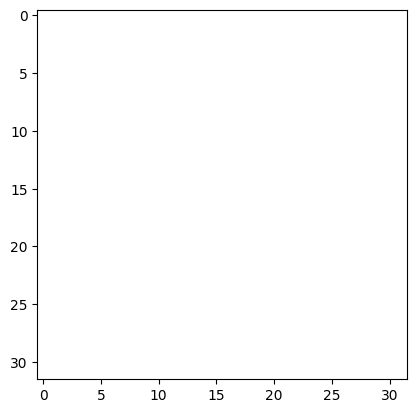

In [116]:
import matplotlib.pyplot as plt
test_input = torch.ones(size=(1,3,32,32))

plt.imshow(test_input[0].detach().permute(1,2,0).cpu().numpy()) # 真っ白

In [210]:
# 適当な画像を拾う
import urllib
import PIL
import io 
import numpy as np

url = 'https://roysk9.github.io/profile.jpg'

with urllib.request.urlopen(url) as web_file:
    data = web_file.read()
a = PIL.Image.open(io.BytesIO(data))
a = a.resize(size=(32,32))
imgs = np.array(a)[...,:3]

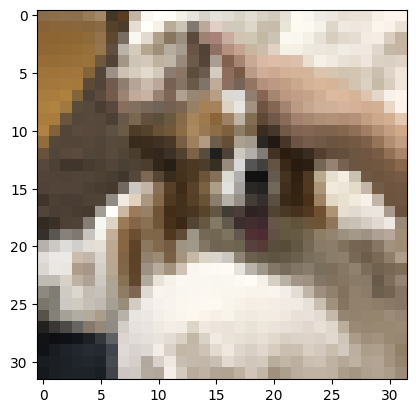

In [211]:
plt.imshow(imgs)

In [212]:
def imagenet_normalize(imgs):
    imagenet_mean = torch.Tensor([0.485, 0.456, 0.406])
    imagenet_std = torch.Tensor([0.229, 0.224, 0.225])
    imgs = (imgs - imagenet_mean)/(imagenet_std)
    return imgs

In [213]:
imgs = imgs.astype(np.float32)
imgs /= 255
imgs = imagenet_normalize(torch.Tensor(imgs))
#test_imgs = torch.Tensor(imgs).permute(2,0,1).unsqueeze(0)
test_imgs = imgs.permute(2,0,1).unsqueeze(0)
ori_img = imgs.unsqueeze(0)

In [214]:
print(imgs.shape)
print(test_imgs.shape)
print(ori_img.shape)
print(mask.shape)

torch.Size([32, 32, 3])
torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 32, 3])
torch.Size([1, 32, 32, 3])


In [215]:
loss,pred,mask = model(test_imgs)
# visualize pred imgs
y = model.unpatchify(pred)
pred_img = torch.einsum('nchw->nhwc', y).detach().cpu()

# visualize mask
mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embedding.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

#ori_img = torch.einsum('nchw->nhwc', imgs)

# masked image
im_masked = ori_img * (1 - mask)

# MAE reconstruction pasted with visible patches
im_paste = ori_img * (1 - mask) + pred_img * mask

In [216]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

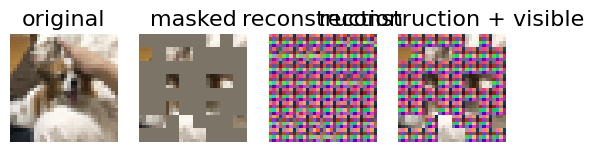

In [217]:
fig = plt.figure()
plt.subplot(1, 4, 1)
show_image(ori_img[0], "original")

plt.subplot(1, 4, 2)
show_image(im_masked[0], "masked")

plt.subplot(1, 4, 3)
show_image(pred_img[0], "reconstruction")

plt.subplot(1, 4, 4)
show_image(im_paste[0], "reconstruction + visible")